# Import des librairies

In [15]:
#Import des bibliothèques
import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV # Pour répartir les données
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from Filtering import OTSU_threshold
from Filtering import filter_color_threshold 
from Filtering import filter_Kmeans1,filter_Kmeans2
from Filtering import filter_MeanShift

ModuleNotFoundError: No module named 'cv2'

In [18]:
pip install opencv

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd

# Import du Dataframe df_Infos
#### Ce dataframe contient les informations de chaque image du dataset (chemin, type, clé, nom, extension, taille, width, height)

In [9]:
path='/Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/'
df_infos = pd.read_csv(path + 'img_info.csv')
df_infos.head()

,file,type,key,name,ext,dimensions,dim_w,dim_h
0,/Users/emilienbonhomme/Desktop/DataScientest -...,basophil,BA,BA_689200,jpg,"(363, 360)",363,360
1,/Users/emilienbonhomme/Desktop/DataScientest -...,basophil,BA,BA_883452,jpg,"(363, 360)",363,360
2,/Users/emilienbonhomme/Desktop/DataScientest -...,basophil,BA,BA_382161,jpg,"(369, 366)",369,366
3,/Users/emilienbonhomme/Desktop/DataScientest -...,basophil,BA,BA_175579,jpg,"(363, 360)",363,360
4,/Users/emilienbonhomme/Desktop/DataScientest -...,basophil,BA,BA_775722,jpg,"(363, 360)",363,360


# Faire une fonction pour créer le dataset (.csv)

In [3]:
def dataset_creation(dataset, nb_img, size_img, filter_img):
    start = time.time()
    df = pd.DataFrame()
    data = []
        
    if nb_img != "all":
        size = nb_img
        for i in dataset["type"].value_counts().index:
            df_type= dataset[dataset["type"]==i]
            df_tmp = df_type.sample(n=size)
            df = pd.concat([df,df_tmp], axis = 0)
        df = df.reset_index()
    
    else:
        df = dataset
    
    for i in df.index: # pour chaque index 
        filename = df.loc[i,'file']
        t_cell = [df.loc[i,"type"]]
        
        if filter_img == "rgb":
            img = cv2.imread(filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            dim_img = "3d"
        
        elif filter_img == "gray":
            img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
            dim_img = "2d"

        elif filter_img == "hsv":
            img = cv2.imread(filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            dim_img = "3d"
        
        elif filter_img == "lab":
            img = cv2.imread(filename,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            dim_img = "3d"
            
        elif filter_img == "canny":
            img = cv2.imread(filename,cv2.IMREAD_COLOR)
            img = cv2.GaussianBlur(img,(3,3),1)
            img = cv2.Canny(img,125,250)
            dim_img = "2d"
        
        elif filter_img == "otsu":
            img = OTSU_threshold(filename)
            dim_img = "2d"
        
        elif filter_img == "kmeans1":
            img = filter_Kmeans1(filename)
            img.shape
            dim_img = "3d"
        
        elif filter_img == "kmeans2":
            img = filter_Kmeans2(filename)
            dim_img = "3d"
        
        elif filter_img == "threshold_color":
            img = filter_color_threshold(filename)
            dim_img = "3d"
            
        elif filter_img == "threshold_color_g":
            img = filter_color_threshold(filename)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                                                                    
            dim_img = "2d"
        #elif filter_img == "otsu_canny":
           # img = filter_color_threshold(filename)
           # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                                                                    
           # dim_img = "2d"
            
        #elif filter_img == "mean_shift":
        #   img = filter_MeanShift(filename)
        #   dim_img = "3d"
            
        else:
            print("Select 'rgb','gray, 'hsv', 'lab', 'canny', 'otsu', 'kmeans1', 'kmeans2', 'threshold_color'")
        
        
        img = cv2.resize(img,dsize = (size_img,size_img))

        if(dim_img == "2d"):
            flat_image = img.reshape(img.shape[0]*img.shape[1])
            
        else:
            flat_image = img.reshape(img.shape[0]*img.shape[1]*img.shape[2])
        
        data.append(np.concatenate((t_cell,flat_image),axis=0))
    
    data_df = pd.DataFrame(data)
    data_df = data_df.rename(columns={data_df.columns[0]:'type'})
    
    data_df.to_csv('/Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/dataset_' + str(nb_img) + '(img) - ' + str(size_img) +'x' + str(size_img) + '_' + str(filter_img)+ '.csv')
    
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')
    return data_df
    

# Fonction pour charger le dataset (.csv)

In [5]:
def load_dataset(dataset_name):
    start = time.time()

    path ='/Users/emilienbonhomme/Desktop/DataScientest - Projet Blood Cell/'
    data_df = pd.read_csv(path + dataset_name, index_col = 0)
    
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')
    
    return data_df

# Fonction pour les modeles

In [13]:
def modeling(dataset,model,display_results_list):

    start = time.time()
    
    target = data_df["type"]
    features = data_df.drop(["type"], axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, random_state = 123)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if 'confusion_matrix' in display_results_list:
        cm_train = pd.crosstab (y_train, y_pred_train, rownames=['Reality'], colnames=['Prediction'])
        display(cm_train)
        
    if 'classification_report' in display_results_list:
        print('CLASSIF ON TRAIN:\n\n', classification_report(y_train, y_pred_train))
    
    if 'confusion_matrix' in display_results_list:
        cm_test = pd.crosstab (y_test, y_pred_test, rownames=['Reality'], colnames=['Prediction'])
        display(cm_test)
        
    if 'classification_report' in display_results_list:
        print('CLASSIF ON TEST:\n\n', classification_report(y_test, y_pred_test))

    if 'scores' in display_results_list:
        acc_train=model.score(X_train, y_train) # retourne l'accuracy du dataset d'entrainement
        acc_test=model.score(X_test, y_test) # retourne l'accuracy du dataset d'entrainement
        print('ACCURACIES:\n',
              '\n train dataset :', round(acc_train*100,2),'%',
              '\n test dataset :', round(acc_test*100,2),'%')
    
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')


# Etude pour définir le rapport Taille/ Nombre d'images

##### Nous possédons un dataset de 17092 image réparties en 8 catégories.

##### Nous allons partir du principe que nous allons utiliser l'intégralité du dataset. 

##### Nous allons donc tenter de définir une taille d'image permettant d'utiliser l'intégralité du dataset sans déteriorer les résultats et en prenant en compte l'overfitting.

##### Par defaut nous utiliserons les images bruts sans filtre, c'est à dire en RGB

# All Taille 60x60 

## RGB

In [9]:
data_df = dataset_creation(df_infos, "all", 60,"rgb")

Durée : 604.151 sec


In [8]:
data_df = load_dataset('dataset_all(img) - 60x60_rgb.csv')
data_df

KeyboardInterrupt: 

In [8]:
data_df

target = data_df["type"]
features = data_df.drop(["type"], axis = 1)

##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2478,0,0,0,0,0,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,1,0,0,0,0,2661,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,124,5,0,65,16,6,6,0
eosinophil,3,603,3,5,2,0,19,4
erythroblast,1,0,251,27,13,0,18,1
ig,6,4,4,498,7,15,55,0
lymphocyte,7,0,6,34,201,0,5,0
monocyte,6,5,0,111,0,161,6,0
neutrophil,0,13,1,13,0,2,638,0
platelet,0,0,2,0,0,0,0,447


ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 85.49 %
Durée : 379.136 sec


##### B. SVM

In [7]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,991,0,0,0,0,0,5,0
eosinophil,0,2471,4,0,0,3,0,0
erythroblast,0,7,1214,0,19,0,0,0
ig,0,0,0,2283,0,16,7,0
lymphocyte,0,0,9,0,952,0,0,0
monocyte,0,1,0,8,0,1122,0,0
neutrophil,1,0,0,5,0,0,2656,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,220,0,0,0,0,0,2,0
eosinophil,0,636,1,0,0,2,0,0
erythroblast,0,2,304,0,5,0,0,0
ig,0,0,0,577,0,6,6,0
lymphocyte,0,0,2,0,251,0,0,0
monocyte,0,0,0,5,0,284,0,0
neutrophil,0,0,0,3,0,0,664,0
platelet,0,0,0,0,0,0,0,449


ACCURACIES:
 
 train dataset : 99.38 % 
 test dataset : 99.01 %
Durée : 1327.104 sec


## Gray

Durée : 115.432 sec


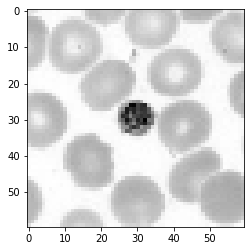

In [10]:
data_df = dataset_creation(df_infos, "all", 60,"gray")

In [9]:
data_df = load_dataset('dataset_all(img) - 60x60_gray.csv')
data_df

Durée : 4.588 sec


,type,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600
0,basophil,234,232,228,230,232,230,233,232,228,...,231,229,231,233,232,231,211,231,231,233
1,basophil,232,213,174,165,164,165,167,174,187,...,230,230,229,229,225,187,172,162,160,160
2,basophil,214,225,232,226,225,226,226,224,229,...,221,220,224,224,225,224,224,225,224,226
3,basophil,177,180,188,217,234,233,231,201,188,...,234,234,234,235,234,235,235,232,235,235
4,basophil,233,234,234,234,234,233,235,234,234,...,219,234,233,234,233,232,232,234,234,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17087,platelet,231,230,232,232,233,232,232,233,233,...,222,232,229,229,231,231,230,189,175,172
17088,platelet,207,234,233,196,187,187,184,186,186,...,192,188,190,191,190,189,190,187,192,234
17089,platelet,185,189,189,187,185,186,184,182,181,...,233,232,233,233,216,180,181,182,181,182
17090,platelet,234,234,234,234,234,234,231,233,232,...,236,235,236,236,236,237,236,236,235,235


##### A. Random Forest

In [12]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 80.29 %
Durée : 95.462 sec


##### B. SVM

In [13]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 89.31 % 
 test dataset : 77.83 %
Durée : 601.95 sec


## HSV

In [6]:
data_df = dataset_creation(df_infos, "all", 60,"hsv")

Durée : 793.181 sec


In [8]:
data_df = load_dataset('dataset_all(img) - 60x60_hsv.csv')

Durée : 24.778 sec


##### A. Random Forest

In [8]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 85.0 %
Durée : 54.786 sec


##### B. SVM

In [9]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 85.42 % 
 test dataset : 79.32 %
Durée : 5005.947 sec


## LAB

In [6]:
data_df = dataset_creation(df_infos, "all", 60,"lab")

Durée : 607.747 sec


In [10]:
data_df = load_dataset('dataset_all(img) - 60x60_lab.csv')

Durée : 326.411 sec


##### A. Random Forest

In [8]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 82.48 %
Durée : 54.874 sec


##### B. SVM

In [ ]:
modeling(data_df, SVC(), ("scores"))

## Canny

Durée : 128.346 sec


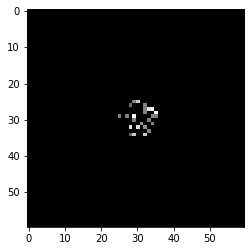

In [6]:
data_df = dataset_creation(df_infos, "all", 60,"canny")

In [18]:
data_df = load_dataset('dataset_all(img) - 60x60_canny.csv')

Durée : 3.354 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 54.61 %
Durée : 69.553 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 88.6 % 
 test dataset : 60.57 %
Durée : 775.982 sec


## Otsu

Durée : 123.21 sec


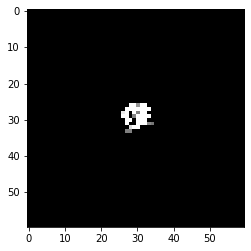

In [7]:
data_df = dataset_creation(df_infos, "all", 60,"otsu")

In [19]:
data_df = load_dataset('dataset_all(img) - 60x60_otsu.csv')

Durée : 3.298 sec


##### A. Random Forest

In [8]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 71.37 %
Durée : 67.339 sec


##### B. SVM

In [9]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 86.12 % 
 test dataset : 75.61 %
Durée : 557.644 sec


## Threshold_color

In [18]:
data_df = dataset_creation(df_infos, "all", 60,"threshold_color")

Durée : 1002.304 sec


In [6]:
data_df = load_dataset('dataset_all(img) - 60x60_threshold_color.csv')

Durée : 27.57 sec


##### A. Random Forest

In [8]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 78.53 %
Durée : 307.619 sec


##### B. SVM

In [7]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 99.17 % 
 test dataset : 98.86 %
Durée : 1015.615 sec


## Threshold Color --> Grayscale

In [15]:
data_df = dataset_creation(df_infos, "all", 60,"threshold_color_g")

Durée : 117.318 sec


In [11]:
data_df = load_dataset('dataset_all(img) - 60x60_threshold_color_g.csv')

Durée : 4.465 sec


##### A. Random Forest

In [16]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores,"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2477,0,0,0,0,1,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,0,0,0,0,0,2662,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,107,15,1,66,23,5,5,0
eosinophil,0,569,5,46,2,2,12,3
erythroblast,3,3,244,23,17,0,19,2
ig,4,40,5,458,7,13,62,0
lymphocyte,14,4,5,22,201,1,5,1
monocyte,11,53,1,121,0,96,7,0
neutrophil,0,30,3,15,0,1,618,0
platelet,0,0,3,0,0,0,0,446


Durée : 36.752 sec


##### B. SVM

In [17]:
modeling(data_df, SVC(), ("confusion_matrix","scores,"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,776,4,3,139,42,30,2,0
eosinophil,2,2243,2,85,9,53,83,1
erythroblast,47,4,1027,66,35,2,52,7
ig,18,81,12,2030,28,60,77,0
lymphocyte,20,3,19,51,852,0,16,0
monocyte,47,103,2,108,3,863,5,0
neutrophil,0,70,14,28,3,6,2541,0
platelet,0,0,18,0,0,0,2,1879


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,128,4,0,59,12,18,1,0
eosinophil,1,499,3,63,4,27,41,1
erythroblast,6,1,230,24,22,0,23,5
ig,19,51,6,428,13,34,38,0
lymphocyte,20,4,12,26,185,0,5,1
monocyte,14,54,0,51,0,165,5,0
neutrophil,0,57,3,17,0,4,586,0
platelet,0,0,8,0,0,0,2,439


Durée : 346.584 sec


## Kmeans1

In [6]:
data_df = dataset_creation(df_infos,"all", 60,"kmeans1")

Durée : 19426.12 sec


In [20]:
data_df = load_dataset('dataset_all(img) - 60x60_kmeans1.csv')

Durée : 26.293 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 83.18 %
Durée : 313.801 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 87.1 % 
 test dataset : 79.88 %
Durée : 3984.465 sec


## Kmeans2

In [8]:
data_df = dataset_creation(df_infos, "all", 60,"kmeans2")

Durée : 2083.854 sec


In [21]:
data_df = load_dataset('dataset_all(img) - 60x60_kmeans2.csv')

Durée : 24.803 sec


##### A. Random Forest

In [9]:
modeling(data_df, RandomForestClassifier(), ("scores"))

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 85.46 %
Durée : 301.194 sec


##### B. SVM

In [10]:
modeling(data_df, SVC(), ("scores"))

ACCURACIES:
 
 train dataset : 88.77 % 
 test dataset : 81.78 %
Durée : 3391.186 sec


# All Taille 45x45

## RGB

In [6]:
data_df = dataset_creation(df_infos, "all", 45,"rgb")

Durée : 211.58 sec


In [8]:
data_df = load_dataset('dataset_all(img) - 45x45_rgb.csv')

Durée : 10.537 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2478,0,0,0,0,0,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,1,0,0,0,0,2661,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,114,9,0,72,18,3,6,0
eosinophil,3,599,1,7,3,0,23,3
erythroblast,1,0,243,28,20,0,17,2
ig,2,5,4,494,10,14,60,0
lymphocyte,6,0,8,27,203,0,9,0
monocyte,7,2,0,125,0,148,7,0
neutrophil,0,11,1,15,0,4,636,0
platelet,0,0,2,0,0,0,0,447


ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 84.35 %
Durée : 173.172 sec


##### B. SVM

In [9]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,990,0,0,0,0,0,6,0
eosinophil,0,2470,5,0,0,3,0,0
erythroblast,0,11,1209,0,20,0,0,0
ig,0,0,0,2280,0,20,6,0
lymphocyte,0,0,8,0,953,0,0,0
monocyte,0,3,0,9,0,1119,0,0
neutrophil,1,0,0,4,0,0,2657,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,220,0,0,0,0,0,2,0
eosinophil,0,636,1,0,0,2,0,0
erythroblast,0,2,305,0,4,0,0,0
ig,0,0,0,574,0,10,5,0
lymphocyte,0,0,1,0,252,0,0,0
monocyte,0,1,0,4,0,284,0,0
neutrophil,0,0,0,2,0,0,665,0
platelet,0,0,0,0,0,0,0,449


ACCURACIES:
 
 train dataset : 99.3 % 
 test dataset : 99.01 %
Durée : 491.294 sec


## Gray

Durée : 68.826 sec


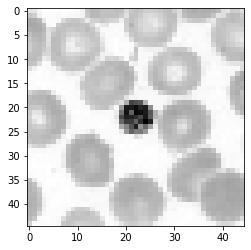

In [6]:
data_df = dataset_creation(df_infos, "all", 45,"gray")

In [22]:
data_df = load_dataset('dataset_all(img) - 45x45_gray.csv')

Durée : 2.027 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 79.38 %
Durée : 57.616 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 89.19 % 
 test dataset : 77.51 %
Durée : 366.546 sec


## HSV

In [10]:
data_df = dataset_creation(df_infos, "all", 45,"hsv")

Durée : 193.249 sec


In [6]:
data_df = load_dataset('dataset_all(img) - 45x45_hsv.csv')

Durée : 10.761 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 84.82 %
Durée : 45.665 sec


##### B. SVM

In [ ]:
modeling(data_df, SVC(), "scores")

## LAB

In [ ]:
data_df = dataset_creation(df_infos, "all", 45,"lab")

In [8]:
data_df = load_dataset('dataset_all(img) - 45x45_lab.csv')

Durée : 11.406 sec


##### A. Random Forest

In [9]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 82.51 %
Durée : 44.963 sec


##### B. SVM

In [ ]:
modeling(data_df, SVC(), "scores")

## Canny

In [10]:
data_df = dataset_creation(df_infos, "all", 45,"canny")

Durée : 78.145 sec


In [23]:
data_df = load_dataset('dataset_all(img) - 45x45_canny.csv')

Durée : 1.437 sec


##### A. Random Forest

In [11]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 53.76 %
Durée : 39.726 sec


##### B. SVM

In [12]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 86.26 % 
 test dataset : 58.09 %
Durée : 594.998 sec


## Otsu

In [14]:
data_df = dataset_creation(df_infos, "all", 45,"otsu")

Durée : 65.867 sec


In [24]:
data_df = load_dataset('dataset_all(img) - 45x45_otsu.csv')

Durée : 1.455 sec


##### A. Random Forest

In [15]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 69.49 %
Durée : 36.604 sec


##### B. SVM

In [16]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 84.25 % 
 test dataset : 74.2 %
Durée : 331.854 sec


## Threshold_color

In [6]:
data_df = dataset_creation(df_infos, "all", 45,"threshold_color")

Durée : 246.082 sec


In [6]:
data_df = load_dataset('dataset_all(img) - 45x45_threshold_color.csv')

Durée : 9.416 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 77.8 %
Durée : 111.804 sec


##### B. SVM

In [7]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 99.17 % 
 test dataset : 98.95 %
Durée : 438.979 sec


## Kmeans1

In [6]:
data_df = dataset_creation(df_infos,"all", 45,"kmeans1")

Durée : 11393.933 sec


In [25]:
data_df = load_dataset('dataset_all(img) - 45x45_kmeans1.csv')

Durée : 8.905 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 100.0 % 
 test dataset : 82.71 %
Durée : 124.189 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 86.6 % 
 test dataset : 79.29 %
Durée : 1550.4 sec


## Kmeans 2

In [6]:
data_df = dataset_creation(df_infos, "all", 45,"kmeans2")

Durée : 2194.059 sec


In [27]:
data_df = load_dataset('dataset_all(img) - 45x45_kmeans2.csv')

Durée : 8.414 sec


##### A. Random Forest

In [26]:
modeling(data_df, RandomForestClassifier(), "scores")

ACCURACIES:
 
 train dataset : 100.0 % 
 test dataset : 82.13 %
Durée : 12.488 sec


##### B. SVM

In [16]:
modeling(data_df, SVC(), "scores")

ACCURACIES:
 
 train dataset : 87.86 % 
 test dataset : 81.46 %
Durée : 1483.756 sec


# All Taille 30x30

In [5]:
data_df = dataset_creation(df_infos, "all", 30,"rgb")

Durée : 90.681 sec


In [11]:
data_df = load_dataset('dataset_all(img) - 30x30_rgb.csv')

Durée : 3.566 sec


##### A. Random Forest

In [8]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2478,0,0,0,0,0,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,1,0,0,0,0,2661,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,106,14,0,70,20,4,8,0
eosinophil,1,602,4,8,3,0,19,2
erythroblast,0,1,247,30,13,0,18,2
ig,2,7,8,495,8,15,54,0
lymphocyte,10,1,7,28,201,0,6,0
monocyte,8,4,0,121,1,149,6,0
neutrophil,0,13,2,20,0,2,630,0
platelet,0,0,1,0,0,0,0,448


ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 84.18 %
Durée : 73.313 sec


##### B. SVM

In [9]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,759,3,0,170,42,17,5,0
eosinophil,1,2407,0,13,7,0,49,1
erythroblast,30,0,1051,63,39,7,44,6
ig,21,13,12,2102,33,44,81,0
lymphocyte,17,1,22,63,842,0,16,0
monocyte,30,2,1,154,4,930,10,0
neutrophil,2,19,11,38,3,4,2585,0
platelet,0,0,14,0,0,0,2,1883


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,130,4,0,66,14,5,3,0
eosinophil,2,591,2,16,3,0,25,0
erythroblast,6,0,242,21,21,0,19,2
ig,21,7,5,477,8,34,37,0
lymphocyte,10,1,10,30,196,1,5,0
monocyte,11,2,0,63,0,207,6,0
neutrophil,0,24,4,26,1,1,611,0
platelet,0,0,6,0,0,0,2,441


ACCURACIES:
 
 train dataset : 91.85 % 
 test dataset : 84.67 %
Durée : 434.202 sec


# All Taille 20x20

In [6]:
data_df = dataset_creation(df_infos, "all", 20,"rgb")

Durée : 38.116 sec


In [15]:
data_df = load_dataset('dataset_all(img) - 20x20_rgb.csv')

Durée : 1.175 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2478,0,0,0,0,0,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,1,0,0,0,0,2661,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,106,26,1,68,12,2,7,0
eosinophil,1,602,2,13,1,0,20,0
erythroblast,0,0,239,27,21,0,23,1
ig,10,9,7,482,9,17,55,0
lymphocyte,8,0,6,25,210,0,4,0
monocyte,2,3,0,127,0,142,15,0
neutrophil,0,17,3,22,0,1,624,0
platelet,0,0,1,0,0,0,2,446


ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 83.39 %
Durée : 33.033 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,732,5,2,196,40,14,7,0
eosinophil,11,2388,1,21,2,0,55,0
erythroblast,32,0,1051,68,37,5,40,7
ig,36,13,13,2058,22,60,104,0
lymphocyte,34,0,25,69,812,0,21,0
monocyte,36,3,2,151,5,920,14,0
neutrophil,1,19,10,72,7,7,2546,0
platelet,0,0,13,0,0,0,3,1883


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,127,5,0,68,10,9,3,0
eosinophil,8,583,2,16,2,0,28,0
erythroblast,6,2,242,23,21,0,14,3
ig,17,8,6,461,15,35,47,0
lymphocyte,14,2,16,27,187,0,7,0
monocyte,14,1,0,61,0,203,10,0
neutrophil,0,23,7,39,0,3,595,0
platelet,0,0,7,0,0,0,2,440


ACCURACIES:
 
 train dataset : 90.62 % 
 test dataset : 83.01 %
Durée : 217.225 sec


# All Taille 10x10

In [6]:
data_df = dataset_creation(df_infos, "all", 10,"rgb")

Durée : 22.679 sec


In [19]:
data_df = load_dataset('dataset_all(img) - 10x10_rgb.csv')

Durée : 0.231 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,996,0,0,0,0,0,0,0
eosinophil,0,2478,0,0,0,0,0,0
erythroblast,0,0,1240,0,0,0,0,0
ig,0,0,0,2306,0,0,0,0
lymphocyte,0,0,0,0,961,0,0,0
monocyte,0,0,0,0,0,1131,0,0
neutrophil,0,1,0,0,0,0,2661,0
platelet,0,0,0,0,0,0,0,1899


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,64,25,7,77,18,7,24,0
eosinophil,0,578,6,20,2,1,30,2
erythroblast,0,1,216,30,34,0,27,3
ig,6,18,7,447,10,14,86,1
lymphocyte,2,0,19,29,183,2,18,0
monocyte,4,9,0,128,0,132,16,0
neutrophil,1,22,10,31,2,1,599,1
platelet,0,0,5,0,2,0,2,440


ACCURACIES:
 
 train dataset : 99.99 % 
 test dataset : 77.77 %
Durée : 11.513 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,526,30,18,263,62,24,73,0
eosinophil,21,2274,8,53,6,1,113,2
erythroblast,11,1,884,103,152,5,67,17
ig,22,23,29,1891,32,70,239,0
lymphocyte,9,1,70,74,739,1,66,1
monocyte,13,2,2,258,1,821,34,0
neutrophil,5,24,21,93,22,14,2479,4
platelet,0,0,10,0,15,0,5,1869


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,84,10,7,80,16,7,18,0
eosinophil,9,543,3,28,3,3,49,1
erythroblast,5,0,192,21,58,2,27,6
ig,19,15,6,418,7,34,90,0
lymphocyte,3,0,27,27,163,4,28,1
monocyte,3,2,0,90,0,180,14,0
neutrophil,8,29,7,49,6,3,564,1
platelet,0,0,6,0,7,0,2,434


ACCURACIES:
 
 train dataset : 83.98 % 
 test dataset : 75.4 %
Durée : 83.139 sec


# All Taille 1x1

In [6]:
data_df = dataset_creation(df_infos, "all", 1,"rgb")

Durée : 20.237 sec


In [43]:
data_df = load_dataset('dataset_all(img) - 1x1_rgb.csv')

Durée : 0.006 sec


##### A. Random Forest

In [7]:
modeling(data_df, RandomForestClassifier(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,951,6,11,14,5,2,5,2
eosinophil,6,2421,1,20,3,9,16,2
erythroblast,9,3,1204,9,9,2,4,0
ig,7,13,17,2213,15,9,23,9
lymphocyte,7,4,11,20,906,3,6,4
monocyte,3,5,4,11,9,1080,7,12
neutrophil,9,12,8,22,5,6,2590,10
platelet,1,10,1,10,6,3,6,1862


Prediction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Reality,,,,,,,,
basophil,26,26,28,54,33,9,27,19
eosinophil,24,306,15,76,19,26,97,76
erythroblast,24,13,160,48,21,10,24,11
ig,36,81,37,174,50,62,74,75
lymphocyte,25,20,19,73,48,24,28,16
monocyte,9,38,7,73,21,51,27,63
neutrophil,28,97,22,82,34,28,303,73
platelet,12,63,8,66,15,42,51,192


ACCURACIES:
 
 train dataset : 96.74 % 
 test dataset : 36.85 %
Durée : 1.585 sec


##### B. SVM

In [8]:
modeling(data_df, SVC(), ("confusion_matrix","scores"))

Prediction,basophil,eosinophil,erythroblast,ig,neutrophil,platelet
Reality,,,,,,
basophil,3,44,154,643,49,103
eosinophil,0,961,17,738,363,399
erythroblast,0,26,801,333,51,29
ig,0,64,177,1629,101,335
lymphocyte,0,3,95,789,6,68
monocyte,1,28,15,668,50,369
neutrophil,1,136,105,854,1252,314
platelet,0,102,8,484,82,1223


Prediction,basophil,eosinophil,erythroblast,ig,neutrophil,platelet
Reality,,,,,,
basophil,2,8,35,140,11,26
eosinophil,0,269,9,184,94,83
erythroblast,0,5,187,93,13,13
ig,0,17,36,415,24,97
lymphocyte,0,1,27,207,3,15
monocyte,0,10,1,170,12,96
neutrophil,0,54,24,210,297,82
platelet,0,21,3,143,15,267


ACCURACIES:
 
 train dataset : 42.92 % 
 test dataset : 42.03 %
Durée : 49.263 sec


# DEEP LEARNING

In [ ]:
%matplotlib inline
import numpy as np

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense # Pour instancier une couche dense
from keras.utils import np_utils

from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Flatten

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm

import itertools


In [22]:
def CNN (dataset, size_img,img_filter):
    dim = 0
    if img_filter == "rgb":
        dim = 3
    elif img_filter == "hsv":
        dim = 3
    elif img_filter == "lab":
        dim = 3
    elif img_filter == "kmeans1":
        dim = 3
    elif img_filter == "kmeans1":
        dim = 3
    elif img_filter == "threshold_color":
        dim = 3
    else:
        dim = 1
    print(dim)
    
    start = time.time()
    
    data_df = dataset
    
    data_df["type"] = data_df["type"].replace({"neutrophil": "1",
                                    "eosinophil": "2",
                                    "ig": "3",
                                    "platelet": "4",
                                    "erythroblast": "5",
                                    "monocyte": "6",
                                    "basophil": "7",
                                    "lymphocyte": "8"})
    
    target = data_df["type"]
    features = data_df.drop(["type"], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, random_state = 123)
    
    X_train = np.array(X_train)
    X_train= X_train.reshape(-1, size_img,size_img,dim)

    X_test = np.array(X_test)
    X_test= X_test.reshape(-1, size_img,size_img,dim)

    X_train = X_train / 255
    X_test = X_test / 255
    
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    num_pixels = X_train.shape[1]
    num_classes = y_test.shape[1]
    
    model = Sequential()

    first_layer = Conv2D(filters = 32,
                         kernel_size = (5, 5),
                         padding = 'valid',
                         input_shape = (size_img, size_img, dim),
                         activation = 'relu')

    second_layer = MaxPooling2D(pool_size = (2, 2))

    model.add(first_layer)
    model.add(second_layer)
    
    third_layer = Dropout(rate = 0.2)

    fourth_layer = Flatten()

    fifth_layer = Dense(units = 128,
                        activation = 'relu')

    output_layer = Dense(units = num_classes,
                         activation='softmax')

    model.add(third_layer)
    model.add(fourth_layer)
    model.add(fifth_layer)
    model.add(output_layer)
    
    model.compile(loss='categorical_crossentropy', # fonction de perte
              optimizer='adam',                    # algorithme d'optimisation
              metrics=['accuracy'])                # métrique d'évaluation

    training_history = model.fit(X_train, y_train,
                                 validation_split = 0.2,
                                 epochs = 10,
                                 batch_size = 200)
    
    train_acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    
    # Labels des axes
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Courbe de la précision sur l'échantillon d'entrainement
    plt.plot(np.arange(1 , 11, 1),
             training_history.history['accuracy'],
             label = 'Training Accuracy',
             color = 'blue')

    # Courbe de la précision sur l'échantillon de validation
    plt.plot(np.arange(1 , 11, 1),
             training_history.history['val_accuracy'], 
             label = 'Validation Accuracy',
             color = 'red')

    
    
    # Affichage de la légende
    plt.legend()
    # Affichage de la figure
    plt.show()
    
    test_pred = model.predict(X_test)

    test_pred_class = test_pred.argmax(axis = 1)
    y_test_class = y_test.argmax(axis = 1)

    print(metrics.classification_report(y_test_class, test_pred_class))
    
    
    
    
    #Réponse valable:
    cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
    print(cnf_matrix)

    ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
    classes = range(0,10)

    plt.figure()

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()
    
    
    
    error_indexes = []
    for i in range(len(test_pred)):
        if (test_pred_class[i] != y_test_class[i]):
            if(y_test_class[i] == 5 or y_test_class[i] == 3):
                if(test_pred_class[i] == 5 or test_pred_class[i] == 3):
                    error_indexes += [i]

    j = 1
    for i in np.random.choice(error_indexes, size = 3):
        img = X_test[i] 
        img = img.reshape(size_img, size_img,dim)

        plt.subplot(1, 3, j)
        j = j + 1
        plt.axis('off')
        plt.imshow(img, cmap=cm.binary, interpolation='None')
        plt.title('True Label: ' + str(y_test_class[i]) \
                  + '\n' + 'Prediction: '+ str(test_pred_class[i]) \
                  + '\n' + 'Confidence: '+ str(round(test_pred[i][test_pred_class[i]], 2)))
        
    end = time.time()
    duration = end - start
    print('Durée :', round(duration,3), 'sec')
    

# Taille 60x60

### rgb

In [11]:
data_df = load_dataset('dataset_all(img) - 60x60_rgb.csv')

Durée : 35.714 sec


Epoch 1/10
55/55 [==============================] - 16s 289ms/step - loss: 1.5449 - accuracy: 0.4719 - val_loss: 1.0240 - val_accuracy: 0.6197
Epoch 2/10
55/55 [==============================] - 16s 282ms/step - loss: 0.8649 - accuracy: 0.7116 - val_loss: 0.7318 - val_accuracy: 0.7810
Epoch 3/10
55/55 [==============================] - 15s 280ms/step - loss: 0.6887 - accuracy: 0.7714 - val_loss: 0.6218 - val_accuracy: 0.7894
Epoch 4/10
55/55 [==============================] - 16s 282ms/step - loss: 0.5675 - accuracy: 0.8182 - val_loss: 0.5850 - val_accuracy: 0.7996
Epoch 5/10
55/55 [==============================] - 16s 289ms/step - loss: 0.4919 - accuracy: 0.8367 - val_loss: 0.4877 - val_accuracy: 0.8307
Epoch 6/10
55/55 [==============================] - 16s 283ms/step - loss: 0.4372 - accuracy: 0.8578 - val_loss: 0.4563 - val_accuracy: 0.8431
Epoch 7/10
55/55 [==============================] - 16s 282ms/step - loss: 0.3735 - accuracy: 0.8786 - val_loss: 0.3998 - val_accuracy: 0.8687

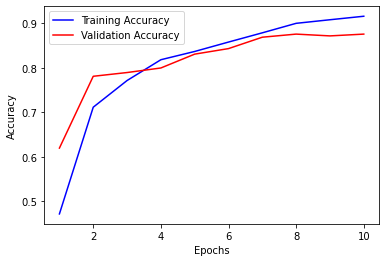

              precision    recall  f1-score   support

           1       0.96      0.95      0.95       667
           2       0.96      0.97      0.96       639
           3       0.77      0.79      0.78       589
           4       0.99      0.97      0.98       449
           5       0.78      0.89      0.83       311
           6       0.81      0.82      0.82       289
           7       0.95      0.72      0.82       222
           8       0.87      0.85      0.86       253

    accuracy                           0.89      3419
   macro avg       0.88      0.87      0.87      3419
weighted avg       0.89      0.89      0.89      3419

[[632   6  21   0   7   1   0   0]
 [  8 621   7   0   1   1   0   1]
 [ 18  12 465   0  33  44   7  10]
 [  0   0   0 437  12   0   0   0]
 [  1   1  12   6 277   3   0  11]
 [  0   1  46   0   5 236   1   0]
 [  0   8  38   0   2   4 159  11]
 [  0   1  18   0  19   1   0 214]]


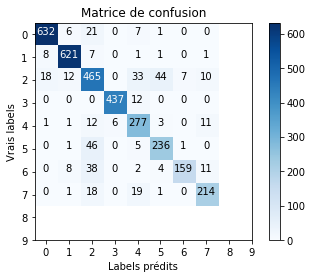

Durée : 161.782 sec


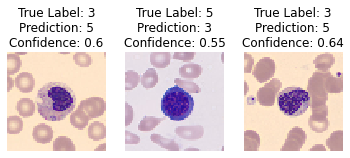

In [12]:
CNN(data_df,60, "rgb")

### gray

In [13]:
data_df = load_dataset('dataset_all(img) - 60x60_gray.csv')

Durée : 5.123 sec


1
Epoch 1/10
55/55 [==============================] - 13s 237ms/step - loss: 1.5816 - accuracy: 0.4498 - val_loss: 1.2217 - val_accuracy: 0.5466
Epoch 2/10
55/55 [==============================] - 13s 229ms/step - loss: 1.0102 - accuracy: 0.6371 - val_loss: 0.9003 - val_accuracy: 0.6969
Epoch 3/10
55/55 [==============================] - 13s 231ms/step - loss: 0.8328 - accuracy: 0.7132 - val_loss: 0.7964 - val_accuracy: 0.7298
Epoch 4/10
55/55 [==============================] - 13s 241ms/step - loss: 0.7228 - accuracy: 0.7509 - val_loss: 0.7309 - val_accuracy: 0.7473
Epoch 5/10
55/55 [==============================] - 13s 236ms/step - loss: 0.6704 - accuracy: 0.7712 - val_loss: 0.7038 - val_accuracy: 0.7455
Epoch 6/10
55/55 [==============================] - 13s 233ms/step - loss: 0.6068 - accuracy: 0.7973 - val_loss: 0.6838 - val_accuracy: 0.7609
Epoch 7/10
55/55 [==============================] - 13s 229ms/step - loss: 0.5643 - accuracy: 0.8141 - val_loss: 0.6492 - val_accuracy: 0.76

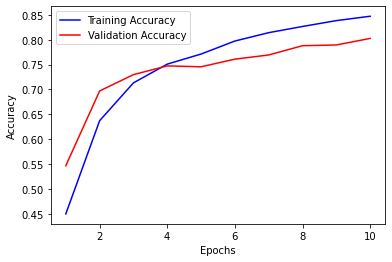

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       667
           2       0.80      0.77      0.79       639
           3       0.65      0.73      0.69       589
           4       0.98      0.96      0.97       449
           5       0.78      0.80      0.79       311
           6       0.68      0.55      0.61       289
           7       0.77      0.77      0.77       222
           8       0.81      0.79      0.80       253

    accuracy                           0.80      3419
   macro avg       0.80      0.79      0.79      3419
weighted avg       0.80      0.80      0.80      3419

[[606  33  20   0   7   1   0   0]
 [ 30 495  72   2   9  26   0   5]
 [ 22  39 432   0  25  37  22  12]
 [  1   0   0 432  16   0   0   0]
 [  9   4  21   5 250   1   3  18]
 [  6  38  74   0   2 158  11   0]
 [  2   2  25   0   0  10 170  13]
 [  2   5  22   0  10   0  14 200]]


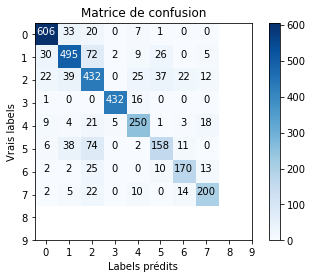

Durée : 131.475 sec


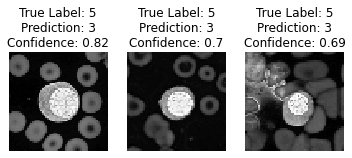

In [14]:
CNN(data_df,60,"gray")

### HSV

In [40]:
data_df = load_dataset('dataset_all(img) - 60x60_hsv.csv')

Durée : 36.656 sec


3
Epoch 1/10
55/55 [==============================] - 17s 300ms/step - loss: 1.7883 - accuracy: 0.3526 - val_loss: 1.1826 - val_accuracy: 0.5770
Epoch 2/10
55/55 [==============================] - 16s 295ms/step - loss: 1.0153 - accuracy: 0.6399 - val_loss: 0.9045 - val_accuracy: 0.6556
Epoch 3/10
55/55 [==============================] - 16s 283ms/step - loss: 0.7703 - accuracy: 0.7426 - val_loss: 0.7205 - val_accuracy: 0.7572
Epoch 4/10
55/55 [==============================] - 16s 283ms/step - loss: 0.6552 - accuracy: 0.7828 - val_loss: 0.6805 - val_accuracy: 0.7686
Epoch 5/10
55/55 [==============================] - 16s 284ms/step - loss: 0.6071 - accuracy: 0.7924 - val_loss: 0.6404 - val_accuracy: 0.7846
Epoch 6/10
55/55 [==============================] - 16s 285ms/step - loss: 0.5373 - accuracy: 0.8172 - val_loss: 0.6041 - val_accuracy: 0.7931
Epoch 7/10
55/55 [==============================] - 16s 283ms/step - loss: 0.5099 - accuracy: 0.8252 - val_loss: 0.6373 - val_accuracy: 0.78

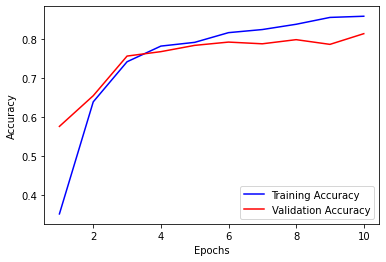

              precision    recall  f1-score   support

           1       0.95      0.87      0.91       667
           2       0.85      0.88      0.87       639
           3       0.69      0.73      0.71       589
           4       0.99      0.96      0.98       449
           5       0.84      0.82      0.83       311
           6       0.69      0.67      0.68       289
           7       0.65      0.81      0.72       222
           8       0.82      0.77      0.79       253

    accuracy                           0.83      3419
   macro avg       0.81      0.81      0.81      3419
weighted avg       0.83      0.83      0.83      3419

[[577  35  29   0  10  15   0   1]
 [  2 561  46   0   5  18   3   4]
 [ 22  34 432   0  10  42  37  12]
 [  0   0   0 433  16   0   0   0]
 [  3   1  24   3 255   1   5  19]
 [  3  20  50   0   1 193  22   0]
 [  0   3  24   0   0   9 179   7]
 [  0   4  20   0   6   0  29 194]]


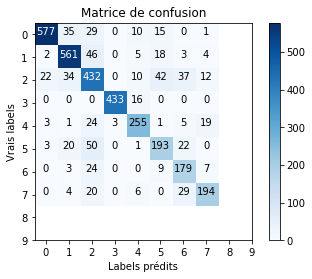

Durée : 163.748 sec


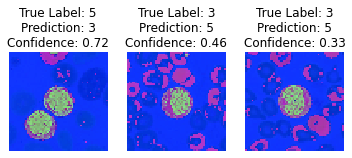

In [42]:
CNN(data_df,60, "hsv")

### LAB

In [43]:
data_df = load_dataset('dataset_all(img) - 60x60_lab.csv')

Durée : 36.215 sec


3
Epoch 1/10
55/55 [==============================] - 16s 287ms/step - loss: 1.9191 - accuracy: 0.3257 - val_loss: 1.3568 - val_accuracy: 0.5002
Epoch 2/10
55/55 [==============================] - 16s 289ms/step - loss: 1.2194 - accuracy: 0.5491 - val_loss: 1.0344 - val_accuracy: 0.6596
Epoch 3/10
55/55 [==============================] - 16s 282ms/step - loss: 0.9824 - accuracy: 0.6502 - val_loss: 0.8917 - val_accuracy: 0.6786
Epoch 4/10
55/55 [==============================] - 15s 281ms/step - loss: 0.8939 - accuracy: 0.6810 - val_loss: 0.8279 - val_accuracy: 0.7181
Epoch 5/10
55/55 [==============================] - 16s 286ms/step - loss: 0.8156 - accuracy: 0.7165 - val_loss: 0.7845 - val_accuracy: 0.7298
Epoch 6/10
55/55 [==============================] - 16s 292ms/step - loss: 0.7707 - accuracy: 0.7314 - val_loss: 0.8105 - val_accuracy: 0.7097
Epoch 7/10
55/55 [==============================] - 16s 286ms/step - loss: 0.7371 - accuracy: 0.7440 - val_loss: 0.7879 - val_accuracy: 0.72

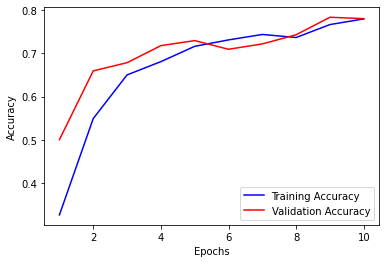

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       667
           2       0.76      0.88      0.82       639
           3       0.63      0.77      0.69       589
           4       0.99      0.94      0.96       449
           5       0.78      0.73      0.75       311
           6       0.76      0.27      0.40       289
           7       0.73      0.59      0.65       222
           8       0.70      0.82      0.75       253

    accuracy                           0.78      3419
   macro avg       0.78      0.74      0.74      3419
weighted avg       0.79      0.78      0.77      3419

[[599  49   8   0   8   1   0   2]
 [ 18 561  40   0   9   5   1   5]
 [ 32  46 452   0   7   8  18  26]
 [  0   0   0 424  25   0   0   0]
 [ 15   5  22   5 227   1   1  35]
 [  1  68 121   0   3  78  17   1]
 [  1   5  56   0   0   9 130  21]
 [  2   0  19   1  12   1  11 207]]


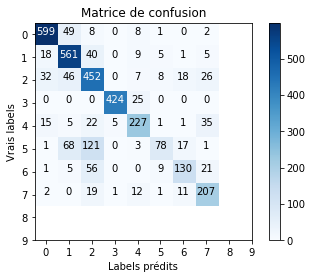

Durée : 162.639 sec


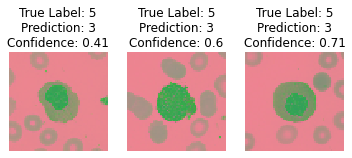

In [44]:
CNN(data_df,60, "lab")

### canny

In [11]:
data_df = load_dataset('dataset_all(img) - 60x60_canny.csv')

Durée : 3.985 sec


1
Epoch 1/10
55/55 [==============================] - 13s 228ms/step - loss: 1.3159 - accuracy: 0.5039 - val_loss: 1.0737 - val_accuracy: 0.6004
Epoch 2/10
55/55 [==============================] - 12s 224ms/step - loss: 0.9901 - accuracy: 0.6334 - val_loss: 1.0286 - val_accuracy: 0.6088
Epoch 3/10
55/55 [==============================] - 12s 223ms/step - loss: 0.8994 - accuracy: 0.6706 - val_loss: 0.9960 - val_accuracy: 0.6135
Epoch 4/10
55/55 [==============================] - 13s 229ms/step - loss: 0.8235 - accuracy: 0.6977 - val_loss: 1.0177 - val_accuracy: 0.6234
Epoch 5/10
55/55 [==============================] - 13s 237ms/step - loss: 0.7484 - accuracy: 0.7334 - val_loss: 0.9902 - val_accuracy: 0.6278
Epoch 6/10
55/55 [==============================] - 12s 223ms/step - loss: 0.6772 - accuracy: 0.7626 - val_loss: 1.0100 - val_accuracy: 0.6186
Epoch 7/10
55/55 [==============================] - 12s 225ms/step - loss: 0.6136 - accuracy: 0.7905 - val_loss: 1.0481 - val_accuracy: 0.61

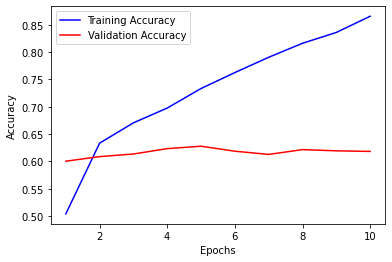

              precision    recall  f1-score   support

           1       0.64      0.58      0.61       667
           2       0.53      0.71      0.61       639
           3       0.55      0.47      0.51       589
           4       0.93      0.93      0.93       449
           5       0.65      0.57      0.60       311
           6       0.60      0.45      0.51       289
           7       0.44      0.50      0.47       222
           8       0.71      0.73      0.72       253

    accuracy                           0.63      3419
   macro avg       0.63      0.62      0.62      3419
weighted avg       0.63      0.63      0.62      3419

[[385 175  54   4  28  10   7   4]
 [ 80 455  52   1   6  29  14   2]
 [ 57 115 278   0   9  32  81  17]
 [  6   0   0 418  23   0   0   2]
 [ 50  12  13  26 176   2   3  29]
 [  7  78  47   0   2 129  24   2]
 [  9  19  48   0   2  12 112  20]
 [  6   7  12   0  26   1  16 185]]


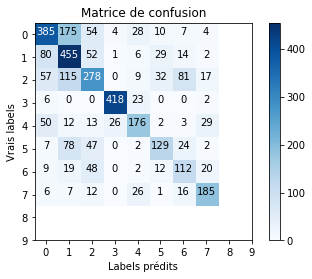

Durée : 127.074 sec


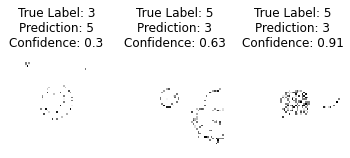

In [12]:
CNN(data_df,60, "canny")

### otsu

In [15]:
data_df = load_dataset('dataset_all(img) - 60x60_otsu.csv')

Durée : 3.943 sec


1
Epoch 1/10
55/55 [==============================] - 13s 238ms/step - loss: 1.1890 - accuracy: 0.5624 - val_loss: 0.8501 - val_accuracy: 0.6973
Epoch 2/10
55/55 [==============================] - 12s 224ms/step - loss: 0.7692 - accuracy: 0.7233 - val_loss: 0.7741 - val_accuracy: 0.7130
Epoch 3/10
55/55 [==============================] - 12s 224ms/step - loss: 0.6743 - accuracy: 0.7543 - val_loss: 0.7585 - val_accuracy: 0.7239
Epoch 4/10
55/55 [==============================] - 13s 232ms/step - loss: 0.6090 - accuracy: 0.7813 - val_loss: 0.7249 - val_accuracy: 0.7415
Epoch 5/10
55/55 [==============================] - 12s 226ms/step - loss: 0.5429 - accuracy: 0.8104 - val_loss: 0.6978 - val_accuracy: 0.7492
Epoch 6/10
55/55 [==============================] - 12s 225ms/step - loss: 0.4893 - accuracy: 0.8328 - val_loss: 0.6996 - val_accuracy: 0.7444
Epoch 7/10
55/55 [==============================] - 12s 223ms/step - loss: 0.4512 - accuracy: 0.8447 - val_loss: 0.7250 - val_accuracy: 0.74

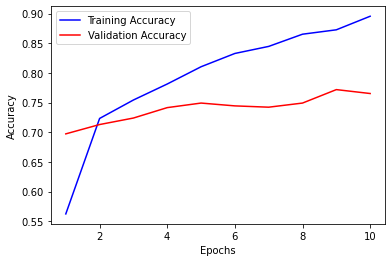

              precision    recall  f1-score   support

           1       0.89      0.92      0.90       667
           2       0.71      0.82      0.76       639
           3       0.65      0.56      0.60       589
           4       0.97      0.94      0.95       449
           5       0.83      0.74      0.78       311
           6       0.46      0.55      0.50       289
           7       0.51      0.40      0.45       222
           8       0.78      0.79      0.79       253

    accuracy                           0.75      3419
   macro avg       0.72      0.71      0.72      3419
weighted avg       0.75      0.75      0.75      3419

[[612  24  17   1   8   3   0   2]
 [ 15 523  32   0   1  49  17   2]
 [ 32  74 330   0   9  89  35  20]
 [  4   0   0 421  24   0   0   0]
 [ 22   3  24  12 229   3   3  15]
 [  3  66  42   0   0 158  20   0]
 [  0  46  31   0   0  38  88  19]
 [  2   2  33   0   4   2   9 201]]


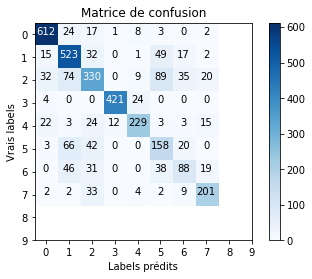

Durée : 127.281 sec


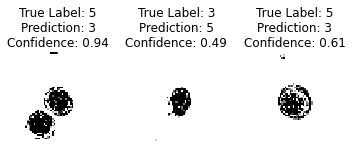

In [16]:
CNN(data_df,60, "otsu")

### Threshold color

In [17]:
data_df = load_dataset('dataset_all(img) - 60x60_threshold_color.csv')

Durée : 28.845 sec


3
Epoch 1/10
55/55 [==============================] - 16s 289ms/step - loss: 1.1024 - accuracy: 0.6059 - val_loss: 0.7533 - val_accuracy: 0.7302
Epoch 2/10
55/55 [==============================] - 15s 279ms/step - loss: 0.6176 - accuracy: 0.7891 - val_loss: 0.5965 - val_accuracy: 0.7890
Epoch 3/10
55/55 [==============================] - 15s 279ms/step - loss: 0.4498 - accuracy: 0.8469 - val_loss: 0.5189 - val_accuracy: 0.8168
Epoch 4/10
55/55 [==============================] - 15s 281ms/step - loss: 0.3676 - accuracy: 0.8737 - val_loss: 0.4813 - val_accuracy: 0.8307
Epoch 5/10
55/55 [==============================] - 15s 281ms/step - loss: 0.3034 - accuracy: 0.8984 - val_loss: 0.4781 - val_accuracy: 0.8314
Epoch 6/10
55/55 [==============================] - 15s 281ms/step - loss: 0.2619 - accuracy: 0.9138 - val_loss: 0.4883 - val_accuracy: 0.8307
Epoch 7/10
55/55 [==============================] - 16s 283ms/step - loss: 0.2302 - accuracy: 0.9283 - val_loss: 0.4496 - val_accuracy: 0.84

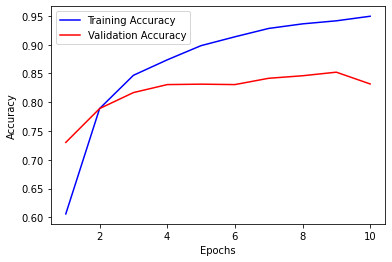

              precision    recall  f1-score   support

           1       0.94      0.77      0.85       667
           2       0.80      0.89      0.84       639
           3       0.71      0.76      0.73       589
           4       0.98      0.96      0.97       449
           5       0.82      0.89      0.85       311
           6       0.77      0.77      0.77       289
           7       0.91      0.79      0.85       222
           8       0.80      0.86      0.83       253

    accuracy                           0.84      3419
   macro avg       0.84      0.84      0.84      3419
weighted avg       0.84      0.84      0.84      3419

[[514 110  28   1   9   0   1   4]
 [ 20 570  36   1   5   4   0   3]
 [  7  22 448   0  19  56  11  26]
 [  0   1   0 432  16   0   0   0]
 [  2   3   8   7 277   3   1  10]
 [  0   4  54   0   5 222   1   3]
 [  0   1  35   0   1   1 176   8]
 [  1   0  22   0   7   3   3 217]]


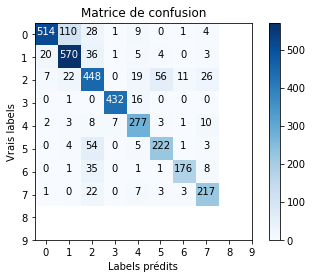

Durée : 167.678 sec


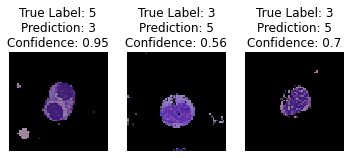

In [19]:
CNN(data_df,60,"threshold_color")

### Threshold color --> Grayscale

In [20]:
data_df = load_dataset('dataset_all(img) - 60x60_threshold_color_g.csv')

Durée : 4.194 sec


In [23]:
CNN(data_df,60,"threshold_color_g")

1


NameError: name 'np_utils' is not defined

### kmeans1

In [20]:
data_df = load_dataset('dataset_all(img) - 60x60_kmeans1.csv')

Durée : 31.393 sec


3
Epoch 1/10
55/55 [==============================] - 16s 286ms/step - loss: 2.0783 - accuracy: 0.3484 - val_loss: 1.3217 - val_accuracy: 0.5316
Epoch 2/10
55/55 [==============================] - 16s 285ms/step - loss: 1.1938 - accuracy: 0.5608 - val_loss: 1.0926 - val_accuracy: 0.6241
Epoch 3/10
55/55 [==============================] - 16s 289ms/step - loss: 0.9958 - accuracy: 0.6576 - val_loss: 0.9446 - val_accuracy: 0.6717
Epoch 4/10
55/55 [==============================] - 16s 295ms/step - loss: 0.8705 - accuracy: 0.6968 - val_loss: 0.8038 - val_accuracy: 0.7159
Epoch 5/10
55/55 [==============================] - 16s 291ms/step - loss: 0.7591 - accuracy: 0.7408 - val_loss: 0.7807 - val_accuracy: 0.7302
Epoch 6/10
55/55 [==============================] - 15s 282ms/step - loss: 0.7105 - accuracy: 0.7571 - val_loss: 0.6868 - val_accuracy: 0.7583
Epoch 7/10
55/55 [==============================] - 15s 279ms/step - loss: 0.6639 - accuracy: 0.7724 - val_loss: 0.6598 - val_accuracy: 0.77

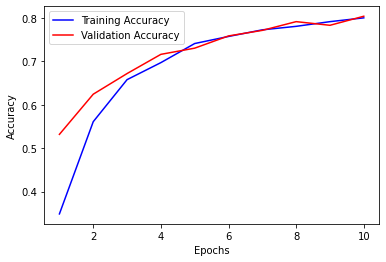

              precision    recall  f1-score   support

           1       0.84      0.92      0.88       667
           2       0.91      0.86      0.88       639
           3       0.71      0.67      0.69       589
           4       0.99      0.96      0.97       449
           5       0.84      0.74      0.79       311
           6       0.61      0.70      0.65       289
           7       0.69      0.60      0.65       222
           8       0.70      0.81      0.75       253

    accuracy                           0.81      3419
   macro avg       0.79      0.78      0.78      3419
weighted avg       0.81      0.81      0.81      3419

[[615  26  13   0   7   5   0   1]
 [ 63 550  12   0   3   8   0   3]
 [ 35  14 392   0   8  77  30  33]
 [  0   0   0 430  19   0   0   0]
 [ 11   5  14   4 231  11   2  33]
 [  5  10  59   0   1 201  13   0]
 [  2   1  42   0   0  23 134  20]
 [  0   1  20   0   7   5  14 206]]


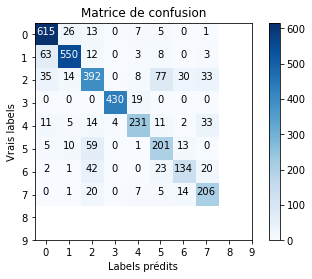

Durée : 163.642 sec


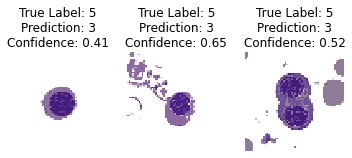

In [22]:
CNN(data_df,60, "kmeans1")

### kmeans2

In [23]:
data_df = load_dataset('dataset_all(img) - 60x60_kmeans2.csv')

Durée : 30.323 sec


3
Epoch 1/10
55/55 [==============================] - 16s 289ms/step - loss: 0.9740 - accuracy: 0.6501 - val_loss: 0.6291 - val_accuracy: 0.7817
Epoch 2/10
55/55 [==============================] - 16s 294ms/step - loss: 0.5335 - accuracy: 0.8209 - val_loss: 0.5561 - val_accuracy: 0.8110
Epoch 3/10
55/55 [==============================] - 16s 288ms/step - loss: 0.4088 - accuracy: 0.8659 - val_loss: 0.5160 - val_accuracy: 0.8201
Epoch 4/10
55/55 [==============================] - 16s 285ms/step - loss: 0.3406 - accuracy: 0.8875 - val_loss: 0.4770 - val_accuracy: 0.8366
Epoch 5/10
55/55 [==============================] - 16s 284ms/step - loss: 0.2808 - accuracy: 0.9089 - val_loss: 0.4642 - val_accuracy: 0.8457
Epoch 6/10
55/55 [==============================] - 15s 276ms/step - loss: 0.2385 - accuracy: 0.9209 - val_loss: 0.4873 - val_accuracy: 0.8267
Epoch 7/10
55/55 [==============================] - 15s 278ms/step - loss: 0.2068 - accuracy: 0.9329 - val_loss: 0.4529 - val_accuracy: 0.85

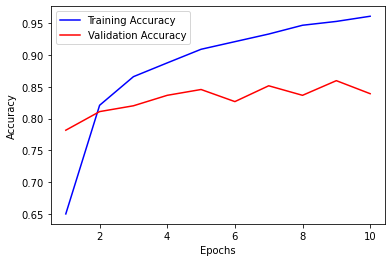

              precision    recall  f1-score   support

           1       0.91      0.90      0.90       667
           2       0.92      0.87      0.90       639
           3       0.72      0.71      0.72       589
           4       0.99      0.99      0.99       449
           5       0.81      0.90      0.85       311
           6       0.70      0.85      0.77       289
           7       0.88      0.71      0.79       222
           8       0.83      0.84      0.84       253

    accuracy                           0.85      3419
   macro avg       0.85      0.85      0.84      3419
weighted avg       0.86      0.85      0.85      3419

[[598  31  23   0  10   4   0   1]
 [ 32 559  38   0   3   3   3   1]
 [ 21   9 418   0  29  82  11  19]
 [  0   0   0 446   3   0   0   0]
 [  3   2  11   4 279   1   1  10]
 [  0   0  35   0   4 247   2   1]
 [  0   4  35   0   4  11 158  10]
 [  2   1  17   0  12   4   5 212]]


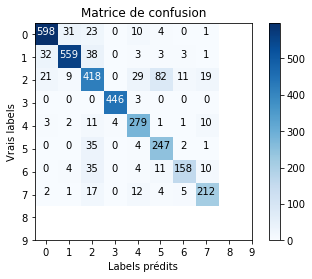

Durée : 162.21 sec


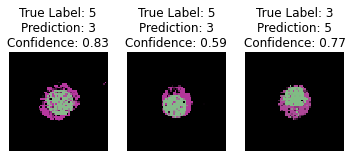

In [24]:
CNN(data_df,60, "kmeans2")

# Taille 45x45

### rgb

In [38]:
data_df = load_dataset('dataset_all(img) - 45x45_rgb.csv')

Durée : 14.458 sec


3
Epoch 1/10
55/55 [==============================] - 9s 162ms/step - loss: 1.7912 - accuracy: 0.3501 - val_loss: 1.2308 - val_accuracy: 0.5338
Epoch 2/10
55/55 [==============================] - 9s 159ms/step - loss: 1.0616 - accuracy: 0.6359 - val_loss: 0.8772 - val_accuracy: 0.6995
Epoch 3/10
55/55 [==============================] - 9s 160ms/step - loss: 0.8330 - accuracy: 0.7155 - val_loss: 0.7196 - val_accuracy: 0.7569
Epoch 4/10
55/55 [==============================] - 9s 158ms/step - loss: 0.7089 - accuracy: 0.7596 - val_loss: 0.6556 - val_accuracy: 0.7843
Epoch 5/10
55/55 [==============================] - 9s 156ms/step - loss: 0.6105 - accuracy: 0.8013 - val_loss: 0.5815 - val_accuracy: 0.7945
Epoch 6/10
55/55 [==============================] - 8s 152ms/step - loss: 0.5508 - accuracy: 0.8185 - val_loss: 0.5289 - val_accuracy: 0.8296
Epoch 7/10
55/55 [==============================] - 8s 152ms/step - loss: 0.5061 - accuracy: 0.8300 - val_loss: 0.4737 - val_accuracy: 0.8494
Epoc

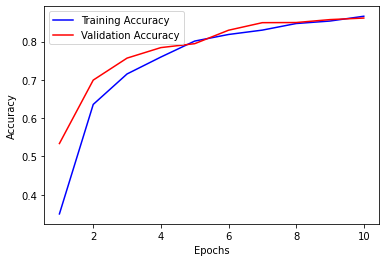

              precision    recall  f1-score   support

           1       0.95      0.93      0.94       667
           2       0.92      0.98      0.95       639
           3       0.80      0.72      0.76       589
           4       0.95      0.97      0.96       449
           5       0.86      0.76      0.81       311
           6       0.74      0.83      0.78       289
           7       0.78      0.78      0.78       222
           8       0.75      0.82      0.78       253

    accuracy                           0.87      3419
   macro avg       0.84      0.85      0.85      3419
weighted avg       0.87      0.87      0.87      3419

[[618  20  17   0   5   6   0   1]
 [  5 628   2   0   0   0   1   3]
 [ 23  16 422   0  11  59  34  24]
 [  0   0   0 437  12   0   0   0]
 [  1   3  13  23 236   7   2  26]
 [  0   2  39   0   2 240   5   1]
 [  1  10  14   0   0   8 174  15]
 [  3   0  21   0   9   4   8 208]]


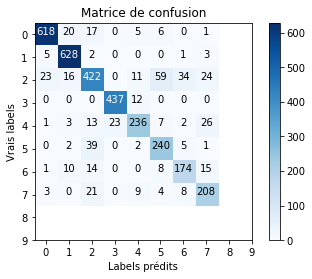

Durée : 90.051 sec


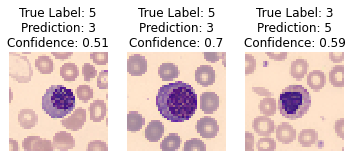

In [39]:
CNN(data_df,45, "rgb")

### gray

In [26]:
data_df = load_dataset('dataset_all(img) - 45x45_gray.csv')

Durée : 3.491 sec


1
Epoch 1/10
55/55 [==============================] - 8s 133ms/step - loss: 1.9508 - accuracy: 0.3243 - val_loss: 1.5452 - val_accuracy: 0.4117
Epoch 2/10
55/55 [==============================] - 7s 128ms/step - loss: 1.3115 - accuracy: 0.5245 - val_loss: 1.1177 - val_accuracy: 0.5766
Epoch 3/10
55/55 [==============================] - 7s 127ms/step - loss: 1.0440 - accuracy: 0.6293 - val_loss: 0.9792 - val_accuracy: 0.6340
Epoch 4/10
55/55 [==============================] - 7s 126ms/step - loss: 0.9396 - accuracy: 0.6656 - val_loss: 0.8767 - val_accuracy: 0.6980
Epoch 5/10
55/55 [==============================] - 7s 125ms/step - loss: 0.8429 - accuracy: 0.7022 - val_loss: 0.8001 - val_accuracy: 0.7327
Epoch 6/10
55/55 [==============================] - 7s 125ms/step - loss: 0.7871 - accuracy: 0.7272 - val_loss: 0.7744 - val_accuracy: 0.7320
Epoch 7/10
55/55 [==============================] - 7s 125ms/step - loss: 0.7451 - accuracy: 0.7424 - val_loss: 0.7547 - val_accuracy: 0.7269
Epoc

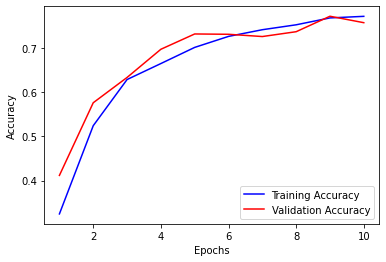

              precision    recall  f1-score   support

           1       0.82      0.94      0.87       667
           2       0.62      0.88      0.73       639
           3       0.76      0.42      0.54       589
           4       0.95      0.98      0.96       449
           5       0.83      0.67      0.74       311
           6       0.57      0.51      0.54       289
           7       0.72      0.64      0.68       222
           8       0.77      0.76      0.77       253

    accuracy                           0.75      3419
   macro avg       0.76      0.73      0.73      3419
weighted avg       0.76      0.75      0.74      3419

[[625  38   2   0   1   1   0   0]
 [ 35 564  14   2   6  15   0   3]
 [ 67 157 248   0  12  70  26   9]
 [  1   0   0 439   9   0   0   0]
 [ 23  10  15  20 209   1   4  29]
 [  4 112  15   0   3 147   8   0]
 [  3  17  20   0   0  23 142  17]
 [  5  14  11   1  12   1  16 193]]


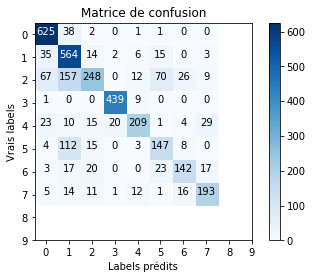

Durée : 71.54 sec


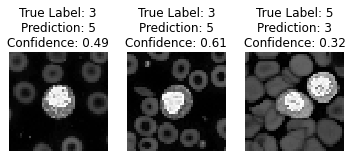

In [27]:
CNN(data_df,45, "gray")

### HSV

In [45]:
data_df = load_dataset('dataset_all(img) - 45x45_hsv.csv')

Durée : 15.264 sec


3
Epoch 1/10
55/55 [==============================] - 9s 162ms/step - loss: 1.4627 - accuracy: 0.4725 - val_loss: 0.9648 - val_accuracy: 0.6676
Epoch 2/10
55/55 [==============================] - 9s 157ms/step - loss: 0.8466 - accuracy: 0.7075 - val_loss: 0.7994 - val_accuracy: 0.7207
Epoch 3/10
55/55 [==============================] - 9s 154ms/step - loss: 0.6920 - accuracy: 0.7622 - val_loss: 0.7224 - val_accuracy: 0.7506
Epoch 4/10
55/55 [==============================] - 9s 156ms/step - loss: 0.6132 - accuracy: 0.7928 - val_loss: 0.6252 - val_accuracy: 0.7865
Epoch 5/10
55/55 [==============================] - 9s 155ms/step - loss: 0.5569 - accuracy: 0.8132 - val_loss: 0.6287 - val_accuracy: 0.7744
Epoch 6/10
55/55 [==============================] - 8s 155ms/step - loss: 0.5180 - accuracy: 0.8242 - val_loss: 0.6028 - val_accuracy: 0.7894
Epoch 7/10
55/55 [==============================] - 9s 155ms/step - loss: 0.4936 - accuracy: 0.8278 - val_loss: 0.6073 - val_accuracy: 0.7806
Epoc

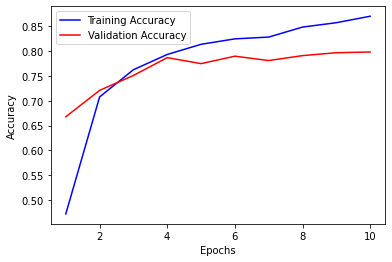

              precision    recall  f1-score   support

           1       0.93      0.91      0.92       667
           2       0.95      0.77      0.85       639
           3       0.57      0.83      0.67       589
           4       0.98      0.98      0.98       449
           5       0.80      0.83      0.82       311
           6       0.74      0.60      0.66       289
           7       0.81      0.58      0.68       222
           8       0.83      0.77      0.80       253

    accuracy                           0.81      3419
   macro avg       0.83      0.78      0.80      3419
weighted avg       0.84      0.81      0.82      3419

[[604   7  41   0  10   5   0   0]
 [  7 492 111   0  11  15   1   2]
 [ 29   7 486   0  13  28  16  10]
 [  0   0   0 439  10   0   0   0]
 [  6   0  23   8 258   0   1  15]
 [  3   9  96   0   3 173   5   0]
 [  0   0  68   0   0  13 129  12]
 [  1   1  30   0  16   1   8 196]]


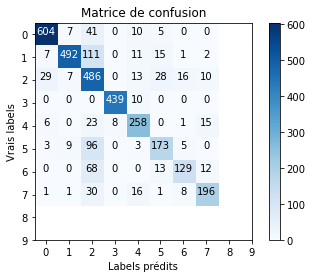

Durée : 89.854 sec


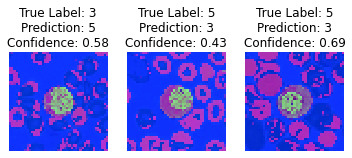

In [46]:
CNN(data_df,45, "hsv")

### LAB

In [47]:
data_df = load_dataset('dataset_all(img) - 45x45_lab.csv')

Durée : 13.487 sec


3
Epoch 1/10
55/55 [==============================] - 9s 162ms/step - loss: 1.9909 - accuracy: 0.2777 - val_loss: 1.6061 - val_accuracy: 0.4899
Epoch 2/10
55/55 [==============================] - 9s 162ms/step - loss: 1.3880 - accuracy: 0.4779 - val_loss: 1.1986 - val_accuracy: 0.5331
Epoch 3/10
55/55 [==============================] - 9s 158ms/step - loss: 1.1173 - accuracy: 0.5903 - val_loss: 1.0196 - val_accuracy: 0.6585
Epoch 4/10
55/55 [==============================] - 9s 158ms/step - loss: 1.0173 - accuracy: 0.6280 - val_loss: 1.0746 - val_accuracy: 0.5832
Epoch 5/10
55/55 [==============================] - 9s 156ms/step - loss: 0.9372 - accuracy: 0.6615 - val_loss: 0.9073 - val_accuracy: 0.6775
Epoch 6/10
55/55 [==============================] - 9s 163ms/step - loss: 0.9020 - accuracy: 0.6838 - val_loss: 0.8657 - val_accuracy: 0.7057
Epoch 7/10
55/55 [==============================] - 9s 163ms/step - loss: 0.8703 - accuracy: 0.6966 - val_loss: 0.8875 - val_accuracy: 0.6764
Epoc

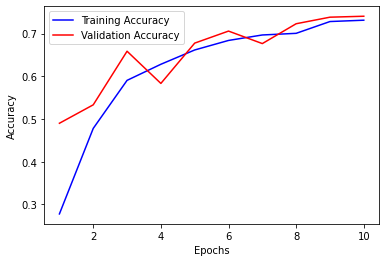

              precision    recall  f1-score   support

           1       0.88      0.85      0.86       667
           2       0.77      0.81      0.79       639
           3       0.68      0.52      0.59       589
           4       0.98      0.95      0.96       449
           5       0.78      0.67      0.72       311
           6       0.55      0.51      0.53       289
           7       0.51      0.72      0.60       222
           8       0.56      0.83      0.67       253

    accuracy                           0.74      3419
   macro avg       0.71      0.73      0.72      3419
weighted avg       0.75      0.74      0.74      3419

[[567  50   8   0  17   6   0  19]
 [ 33 518  41   1   6  24   6  10]
 [ 26  46 304   0   4  75  81  53]
 [  0   0   0 426  23   0   0   0]
 [ 16   6   7   7 208   1   8  58]
 [  1  41  62   0   2 146  36   1]
 [  0   5  21   0   1  12 160  23]
 [  4   3   5   1   7   1  21 211]]


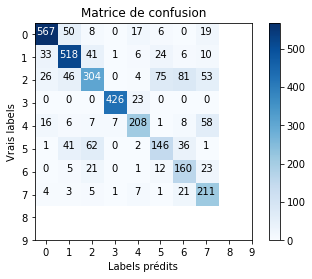

Durée : 91.484 sec


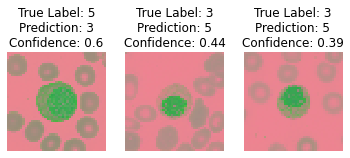

In [48]:
CNN(data_df,45, "lab")

### canny

In [28]:
data_df = load_dataset('dataset_all(img) - 45x45_canny.csv')

Durée : 1.964 sec


1
Epoch 1/10
55/55 [==============================] - 8s 133ms/step - loss: 1.4877 - accuracy: 0.4391 - val_loss: 1.1592 - val_accuracy: 0.5580
Epoch 2/10
55/55 [==============================] - 7s 131ms/step - loss: 1.1014 - accuracy: 0.5818 - val_loss: 1.0784 - val_accuracy: 0.5876
Epoch 3/10
55/55 [==============================] - 7s 131ms/step - loss: 1.0383 - accuracy: 0.6116 - val_loss: 1.0681 - val_accuracy: 0.5854
Epoch 4/10
55/55 [==============================] - 7s 133ms/step - loss: 0.9875 - accuracy: 0.6274 - val_loss: 1.0628 - val_accuracy: 0.5905
Epoch 5/10
55/55 [==============================] - 7s 130ms/step - loss: 0.9334 - accuracy: 0.6497 - val_loss: 1.0579 - val_accuracy: 0.5967
Epoch 6/10
55/55 [==============================] - 7s 132ms/step - loss: 0.8993 - accuracy: 0.6707 - val_loss: 1.0349 - val_accuracy: 0.6124
Epoch 7/10
55/55 [==============================] - 7s 132ms/step - loss: 0.8575 - accuracy: 0.6835 - val_loss: 1.0325 - val_accuracy: 0.6143
Epoc

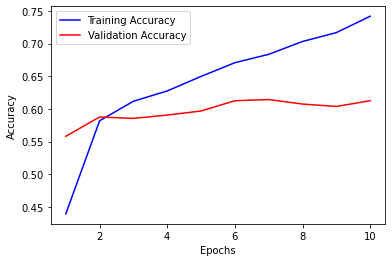

              precision    recall  f1-score   support

           1       0.61      0.54      0.58       667
           2       0.58      0.56      0.57       639
           3       0.46      0.59      0.51       589
           4       0.92      0.92      0.92       449
           5       0.59      0.50      0.54       311
           6       0.47      0.44      0.45       289
           7       0.47      0.33      0.39       222
           8       0.63      0.76      0.69       253

    accuracy                           0.59      3419
   macro avg       0.59      0.58      0.58      3419
weighted avg       0.60      0.59      0.59      3419

[[363 133  86   3  36  26   5  15]
 [ 93 357 118   0   5  56  10   0]
 [ 61  61 345   0  14  37  50  21]
 [  8   0   0 413  27   0   0   1]
 [ 43   8  17  32 154   5   1  51]
 [  9  45  92   0   0 128  13   2]
 [  6   9  87   0   2  21  74  23]
 [ 12   4  13   1  24   2   4 193]]


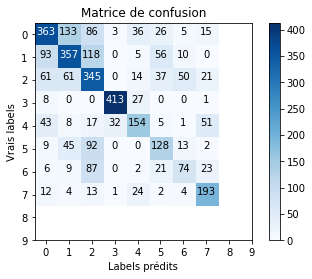

Durée : 74.214 sec


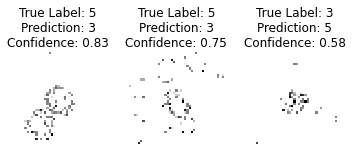

In [29]:
CNN(data_df,45, "canny")

### otsu

In [30]:
data_df = load_dataset('dataset_all(img) - 45x45_otsu.csv')

Durée : 1.731 sec


1
Epoch 1/10
55/55 [==============================] - 8s 133ms/step - loss: 1.1931 - accuracy: 0.5672 - val_loss: 0.8864 - val_accuracy: 0.6731
Epoch 2/10
55/55 [==============================] - 7s 130ms/step - loss: 0.8095 - accuracy: 0.7002 - val_loss: 0.7993 - val_accuracy: 0.6921
Epoch 3/10
55/55 [==============================] - 7s 130ms/step - loss: 0.7250 - accuracy: 0.7335 - val_loss: 0.7918 - val_accuracy: 0.7013
Epoch 4/10
55/55 [==============================] - 7s 130ms/step - loss: 0.6654 - accuracy: 0.7588 - val_loss: 0.7323 - val_accuracy: 0.7199
Epoch 5/10
55/55 [==============================] - 7s 129ms/step - loss: 0.6109 - accuracy: 0.7805 - val_loss: 0.7529 - val_accuracy: 0.7177
Epoch 6/10
55/55 [==============================] - 7s 131ms/step - loss: 0.5646 - accuracy: 0.7988 - val_loss: 0.7452 - val_accuracy: 0.7163
Epoch 7/10
55/55 [==============================] - 7s 129ms/step - loss: 0.5356 - accuracy: 0.8116 - val_loss: 0.7023 - val_accuracy: 0.7543
Epoc

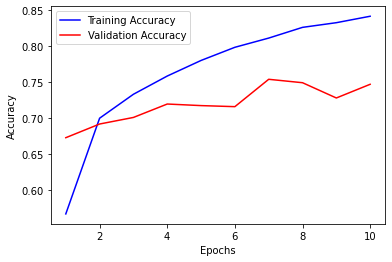

              precision    recall  f1-score   support

           1       0.92      0.90      0.91       667
           2       0.79      0.70      0.74       639
           3       0.56      0.69      0.61       589
           4       0.97      0.95      0.96       449
           5       0.84      0.73      0.78       311
           6       0.65      0.25      0.36       289
           7       0.37      0.65      0.48       222
           8       0.78      0.81      0.80       253

    accuracy                           0.74      3419
   macro avg       0.73      0.71      0.70      3419
weighted avg       0.76      0.74      0.74      3419

[[600  18  36   1  11   0   0   1]
 [ 21 446  81   0   0  13  75   3]
 [ 17  30 404   0  10  16  88  24]
 [  3   0   0 428  18   0   0   0]
 [ 13   3  34  14 228   0   2  17]
 [  0  48 111   0   0  71  58   1]
 [  0  19  38   0   0   8 145  12]
 [  0   1  23   0   3   1  19 206]]


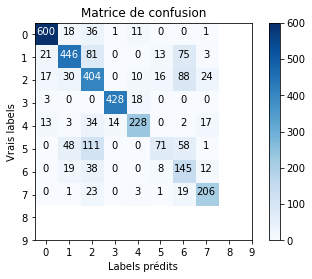

Durée : 73.813 sec


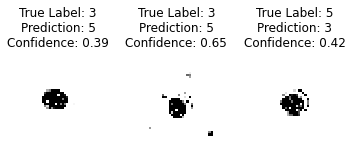

In [31]:
CNN(data_df,45, "otsu")

### Threshold_color

In [32]:
data_df = load_dataset('dataset_all(img) - 45x45_threshold_color.csv')

Durée : 9.952 sec


3
Epoch 1/10
55/55 [==============================] - 9s 160ms/step - loss: 1.1626 - accuracy: 0.5853 - val_loss: 0.7975 - val_accuracy: 0.7155
Epoch 2/10
55/55 [==============================] - 8s 139ms/step - loss: 0.6690 - accuracy: 0.7617 - val_loss: 0.6287 - val_accuracy: 0.7605
Epoch 3/10
55/55 [==============================] - 8s 140ms/step - loss: 0.5198 - accuracy: 0.8200 - val_loss: 0.5834 - val_accuracy: 0.7857
Epoch 4/10
55/55 [==============================] - 8s 143ms/step - loss: 0.4504 - accuracy: 0.8424 - val_loss: 0.5112 - val_accuracy: 0.8249
Epoch 5/10
55/55 [==============================] - 8s 142ms/step - loss: 0.3839 - accuracy: 0.8671 - val_loss: 0.4974 - val_accuracy: 0.8179
Epoch 6/10
55/55 [==============================] - 8s 140ms/step - loss: 0.3298 - accuracy: 0.8854 - val_loss: 0.4786 - val_accuracy: 0.8347
Epoch 7/10
55/55 [==============================] - 8s 140ms/step - loss: 0.2984 - accuracy: 0.9003 - val_loss: 0.5138 - val_accuracy: 0.8102
Epoc

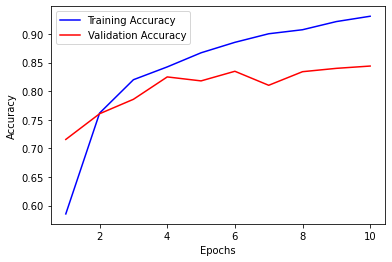

              precision    recall  f1-score   support

           1       0.83      0.89      0.86       667
           2       0.83      0.84      0.83       639
           3       0.75      0.71      0.73       589
           4       0.97      0.97      0.97       449
           5       0.92      0.83      0.87       311
           6       0.79      0.75      0.77       289
           7       0.83      0.85      0.84       222
           8       0.81      0.86      0.84       253

    accuracy                           0.84      3419
   macro avg       0.84      0.84      0.84      3419
weighted avg       0.84      0.84      0.84      3419

[[595  64   4   0   2   0   1   1]
 [ 73 536  24   0   1   2   0   3]
 [ 33  32 419   0   2  49  30  24]
 [  0   0   0 436  13   0   0   0]
 [ 12   6   9  13 257   2   1  11]
 [  0   6  61   0   0 216   3   3]
 [  1   1  21   0   1   0 189   9]
 [  5   0  18   0   4   4   4 218]]


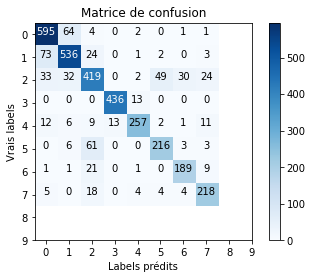

Durée : 81.726 sec


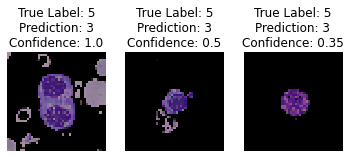

In [33]:
CNN(data_df,45, "threshold_color")

### kmeans1

In [34]:
data_df = load_dataset('dataset_all(img) - 45x45_kmeans2.csv')

Durée : 10.458 sec


3
Epoch 1/10
55/55 [==============================] - 9s 156ms/step - loss: 1.0339 - accuracy: 0.6352 - val_loss: 0.6696 - val_accuracy: 0.7697
Epoch 2/10
55/55 [==============================] - 9s 156ms/step - loss: 0.5936 - accuracy: 0.7955 - val_loss: 0.5850 - val_accuracy: 0.8110
Epoch 3/10
55/55 [==============================] - 9s 156ms/step - loss: 0.4972 - accuracy: 0.8333 - val_loss: 0.5512 - val_accuracy: 0.8168
Epoch 4/10
55/55 [==============================] - 8s 154ms/step - loss: 0.4307 - accuracy: 0.8560 - val_loss: 0.4953 - val_accuracy: 0.8314
Epoch 5/10
55/55 [==============================] - 8s 151ms/step - loss: 0.3819 - accuracy: 0.8698 - val_loss: 0.4823 - val_accuracy: 0.8351
Epoch 6/10
55/55 [==============================] - 8s 151ms/step - loss: 0.3352 - accuracy: 0.8877 - val_loss: 0.4653 - val_accuracy: 0.8366
Epoch 7/10
55/55 [==============================] - 8s 151ms/step - loss: 0.3017 - accuracy: 0.9006 - val_loss: 0.4512 - val_accuracy: 0.8355
Epoc

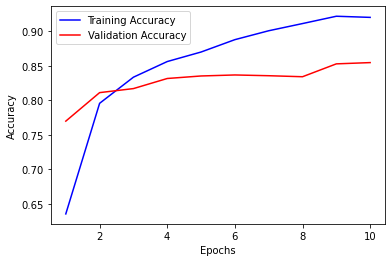

              precision    recall  f1-score   support

           1       0.91      0.88      0.90       667
           2       0.86      0.93      0.89       639
           3       0.71      0.73      0.72       589
           4       0.99      0.97      0.98       449
           5       0.88      0.84      0.86       311
           6       0.82      0.74      0.77       289
           7       0.80      0.85      0.82       222
           8       0.87      0.84      0.85       253

    accuracy                           0.85      3419
   macro avg       0.85      0.85      0.85      3419
weighted avg       0.86      0.85      0.85      3419

[[590  55  16   0   4   2   0   0]
 [ 21 592  26   0   0   0   0   0]
 [ 29  28 429   0  11  44  34  14]
 [  0   0   0 435  14   0   0   0]
 [  2   4  27   3 261   1   2  11]
 [  1   3  65   0   1 213   5   1]
 [  0   7  17   0   1   1 189   7]
 [  2   1  27   0   4   0   7 212]]


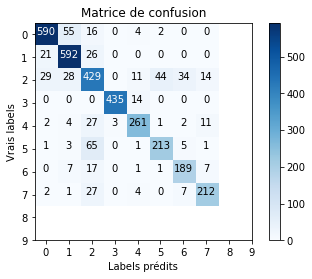

Durée : 88.41 sec


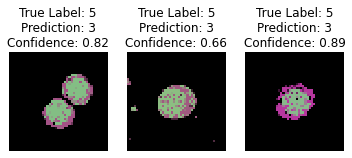

In [35]:
CNN(data_df,45, "kmeans1")

### kmeans2

In [36]:
data_df = load_dataset('dataset_all(img) - 45x45_kmeans2.csv')

Durée : 10.558 sec


3
Epoch 1/10
55/55 [==============================] - 9s 154ms/step - loss: 1.0618 - accuracy: 0.6231 - val_loss: 0.7276 - val_accuracy: 0.7287
Epoch 2/10
55/55 [==============================] - 8s 151ms/step - loss: 0.6235 - accuracy: 0.7806 - val_loss: 0.6003 - val_accuracy: 0.7941
Epoch 3/10
55/55 [==============================] - 8s 151ms/step - loss: 0.5115 - accuracy: 0.8220 - val_loss: 0.5286 - val_accuracy: 0.8205
Epoch 4/10
55/55 [==============================] - 8s 151ms/step - loss: 0.4457 - accuracy: 0.8527 - val_loss: 0.5132 - val_accuracy: 0.8179
Epoch 5/10
55/55 [==============================] - 8s 153ms/step - loss: 0.3888 - accuracy: 0.8670 - val_loss: 0.4715 - val_accuracy: 0.8406
Epoch 6/10
55/55 [==============================] - 8s 151ms/step - loss: 0.3484 - accuracy: 0.8821 - val_loss: 0.5078 - val_accuracy: 0.8267
Epoch 7/10
55/55 [==============================] - 8s 153ms/step - loss: 0.3330 - accuracy: 0.8857 - val_loss: 0.4532 - val_accuracy: 0.8435
Epoc

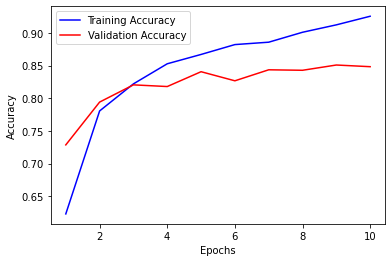

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       667
           2       0.90      0.85      0.88       639
           3       0.68      0.77      0.72       589
           4       0.99      0.99      0.99       449
           5       0.95      0.79      0.86       311
           6       0.79      0.76      0.77       289
           7       0.83      0.81      0.82       222
           8       0.86      0.82      0.84       253

    accuracy                           0.85      3419
   macro avg       0.86      0.84      0.85      3419
weighted avg       0.85      0.85      0.85      3419

[[610  34  19   0   2   2   0   0]
 [ 53 545  40   0   0   0   1   0]
 [ 31  14 452   0   4  55  26   7]
 [  1   0   0 443   5   0   0   0]
 [  5   3  32   6 245   1   1  18]
 [  1   2  60   0   1 220   5   0]
 [  0   6  28   0   0   1 179   8]
 [  2   2  35   0   2   0   4 208]]


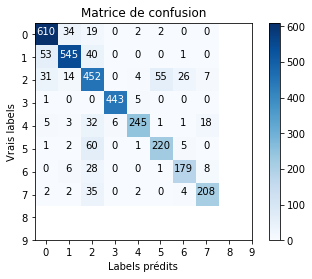

Durée : 86.965 sec


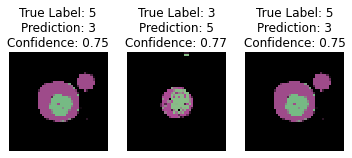

In [37]:
CNN(data_df,45, "kmeans2")